# Funções

In [ ]:
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                           aneis (lista): tamanho do raio do círculo em km
                           lon_r (float): valor da longitude do centro do círculo em graus
                           lat_r (float): valor da latitude do centro do círculo em graus
                           color (str): cor do raio do círculo
                           label (str): legenda

    Parâmetros de saída:
                         latitude e longitude que delimitam os círculos de distância centrado no radar e plota os círculos

    Exemplo:
             evm_plota_aneis_em_geral([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')
    """

    import geopy                              # Biblioteca para geocodificação
    from geopy import distance                # Função para calculo de distância
    import numpy as np

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, lw=0.5)

# Entendendo o arquivo que será utilizado

In [ ]:
import xarray as xr
dir_input = 'output/05_NETCDF_CAPPI/'
ds = xr.open_dataset(f'{dir_input}cappi_3000m_lontras_20230323_212116.nc')
ds

In [ ]:
print(ds['rainrate_z'].min(), ds['rainrate_z'].max())

In [ ]:
ds['rainrate_z']

In [ ]:
import pyart
ds['rainrate_z'].plot(cmap='pyart_LangRainbow12', vmin=1, vmax=50)

# Gera netcdf de chuva acumulada

In [ ]:
%%time
#========================================================================================================================#
#                                              IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                                 DIRETÓRIOS
#========================================================================================================================#
dir_input = 'output/05_NETCDF_CAPPI/'
dir_output = 'output/06_ACUMULADO_PRECIPITACAO/'

#========================================================================================================================#
#                                                 PROCESSAMENTO
#========================================================================================================================#
# datas
datas = ['20230323']
#datas=datas[0:1]
            
# taxa de conversão de 1h para 4.7min 
fator = 4.7/60.

# escolha a estimativa de chuva
estimativa_chuva = 'rainrate_z'
estimativa_chuva = 'rainrate_kdp'
estimativa_chuva = 'rainrate_z_kdp'
estimativa_chuva = 'rainrate_z_zdr_kdp'
#estimativa_chuva = 'rainrate_z_zdr_kdp_filtrokdp'

# loop das datas
for data in datas:

    print('data===>>', data)
    
    # inicializa a variável de soma da chuva
    chuva_total = np.zeros([500,500])

    # lista dos arquivos daquela data
    files = sorted(glob.glob(f'{dir_input}cappi_3000m_lontras_{data}*.nc')) # Exemplo: cappi_3000m_lontras_20230323_212116.nc

    # loop dos arquivos daquela data
    for file in files:

        print('PROCESSANDO ===>>', file)

        # leitura do arquivo netcdf
        ds = xr.open_dataset(file)

        # transforma "NaN" para "0.0"
        chuva_atual = ds[estimativa_chuva][:,:]
        chuva_atual = np.where(~np.isnan(chuva_atual), chuva_atual, 0.0)

        # soma total de chuva
        chuva_total = chuva_total + (chuva_atual*fator)

    # Salva arquivo em formato NETCDF
    # define encoding para compactação dos dados
    encoding = {'rain_acumulado_dia': {'zlib': True}}

    # define as variáveis
    data_vars = {'rain_acumulado_dia': (('lat', 'lon'), 
                                        chuva_total, 
                                        {'units': 'mm/dia', 'long_name': 'Acumulado de Precipitação por Dia', '_FillValue': 0})}
  
    # coordenadas 
    coords = {'lat': ds['lat'].values, 'lon': ds['lon'].values}

    # atributos  
    descricao = "Constant Altitude Plan Position Indicator (CAPPI) de precipitação em 3 km de altitude com resolução espacial horizontal de 1 km para o radar de LONTRAS (SC)"
    attrs = {'description': descricao,                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    dataset = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

    # salva arquivo netcdf
    dataset.to_netcdf(f'{dir_output}chuva_acumulada_lontras_{data}_{estimativa_chuva}.nc',  encoding=encoding)  

# Plota cappi da chuva acumulada

## Testes

In [ ]:
# exemplo do arquivo NETCDF gerado
netcdf = xr.open_dataset('output/06_ACUMULADO_PRECIPITACAO/chuva_acumulada_lontras_20230323_rainrate_z_zdr_kdp_filtrokdp.nc')
netcdf

In [ ]:
netcdf['rain_acumulado_dia']

In [ ]:
# plota mapa 
netcdf['rain_acumulado_dia'][:,:].plot(figsize=(9,7), cmap='pyart_NWSRef', vmin=0, vmax=70)

## Plota figura

rainrate_z
rainrate_kdp
rainrate_z_kdp
rainrate_z_zdr_kdp
rainrate_z_zdr_kdp_filtrokdp


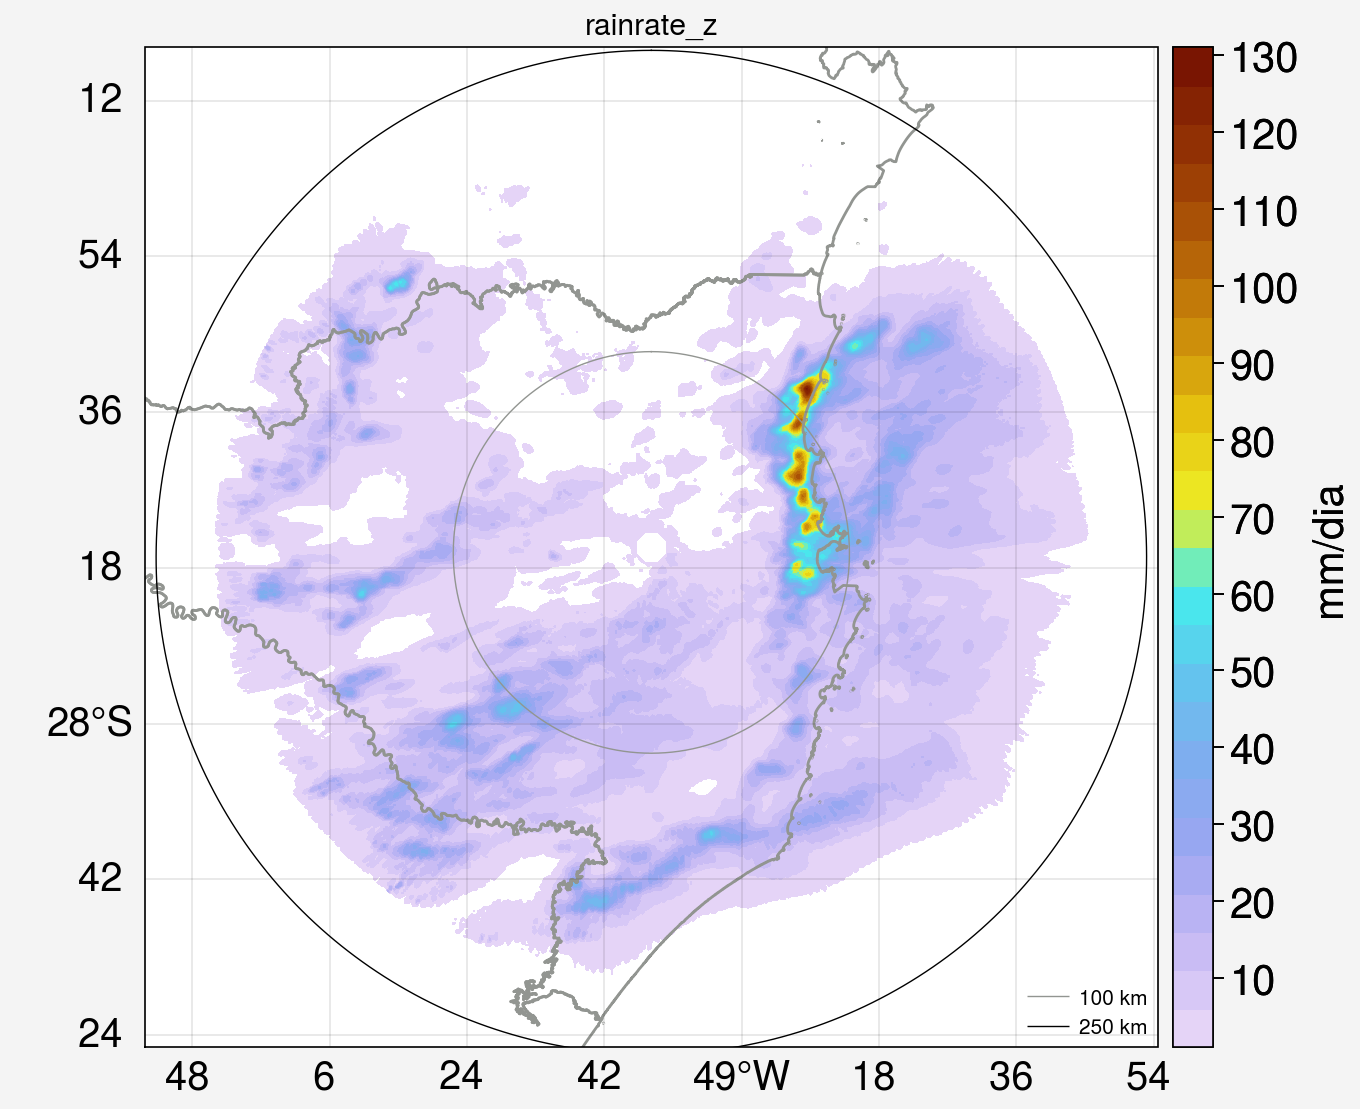

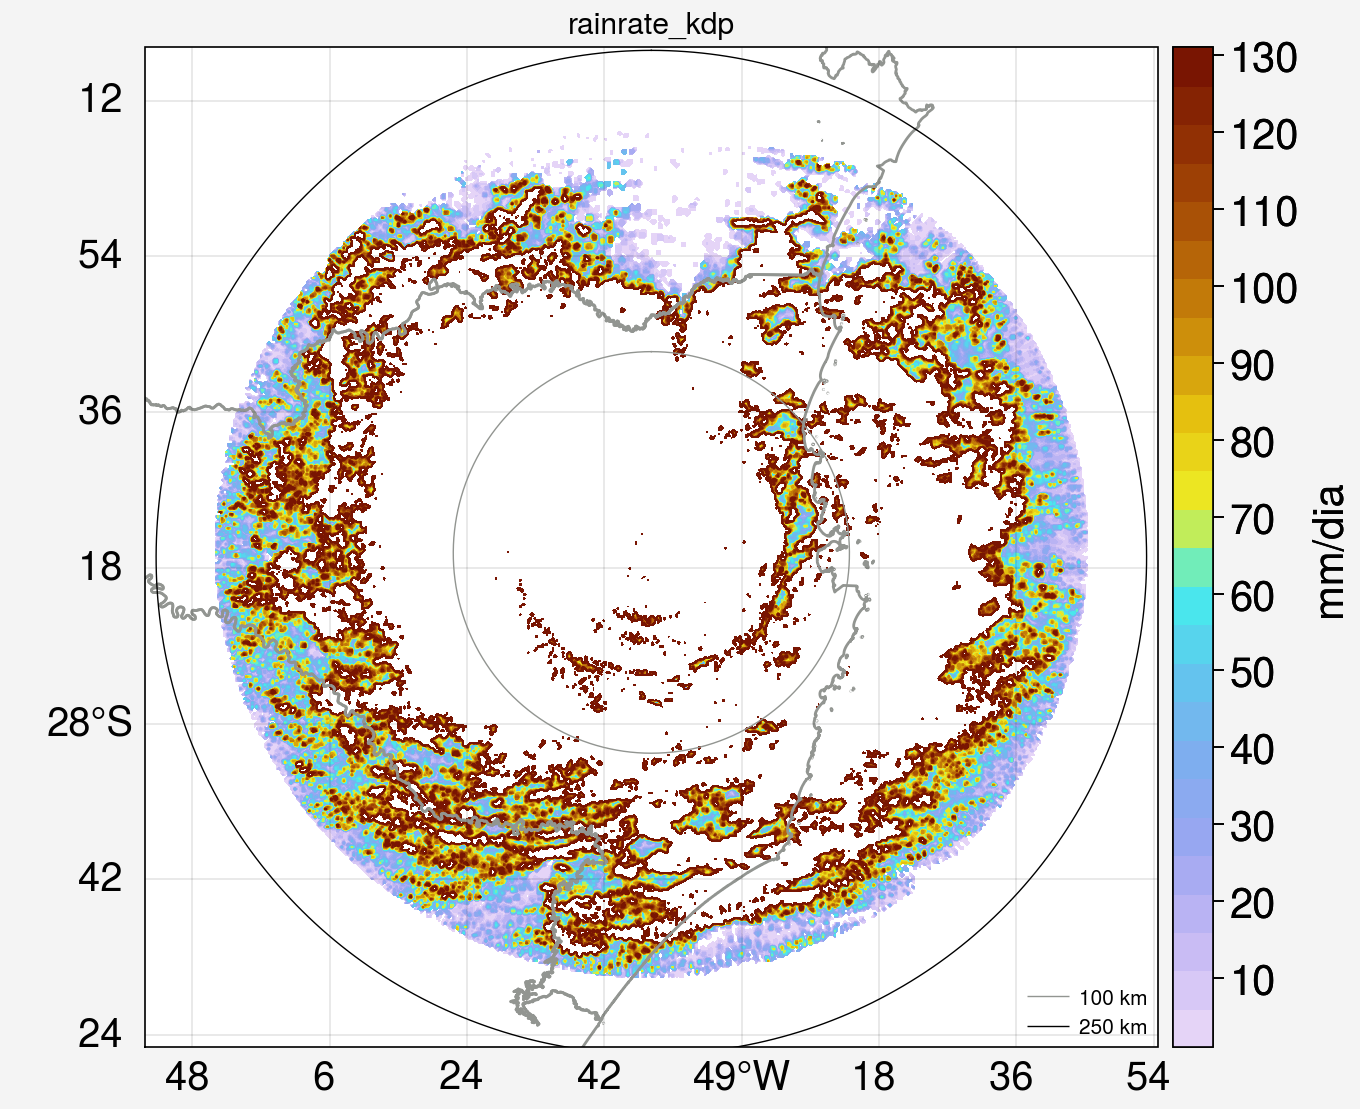

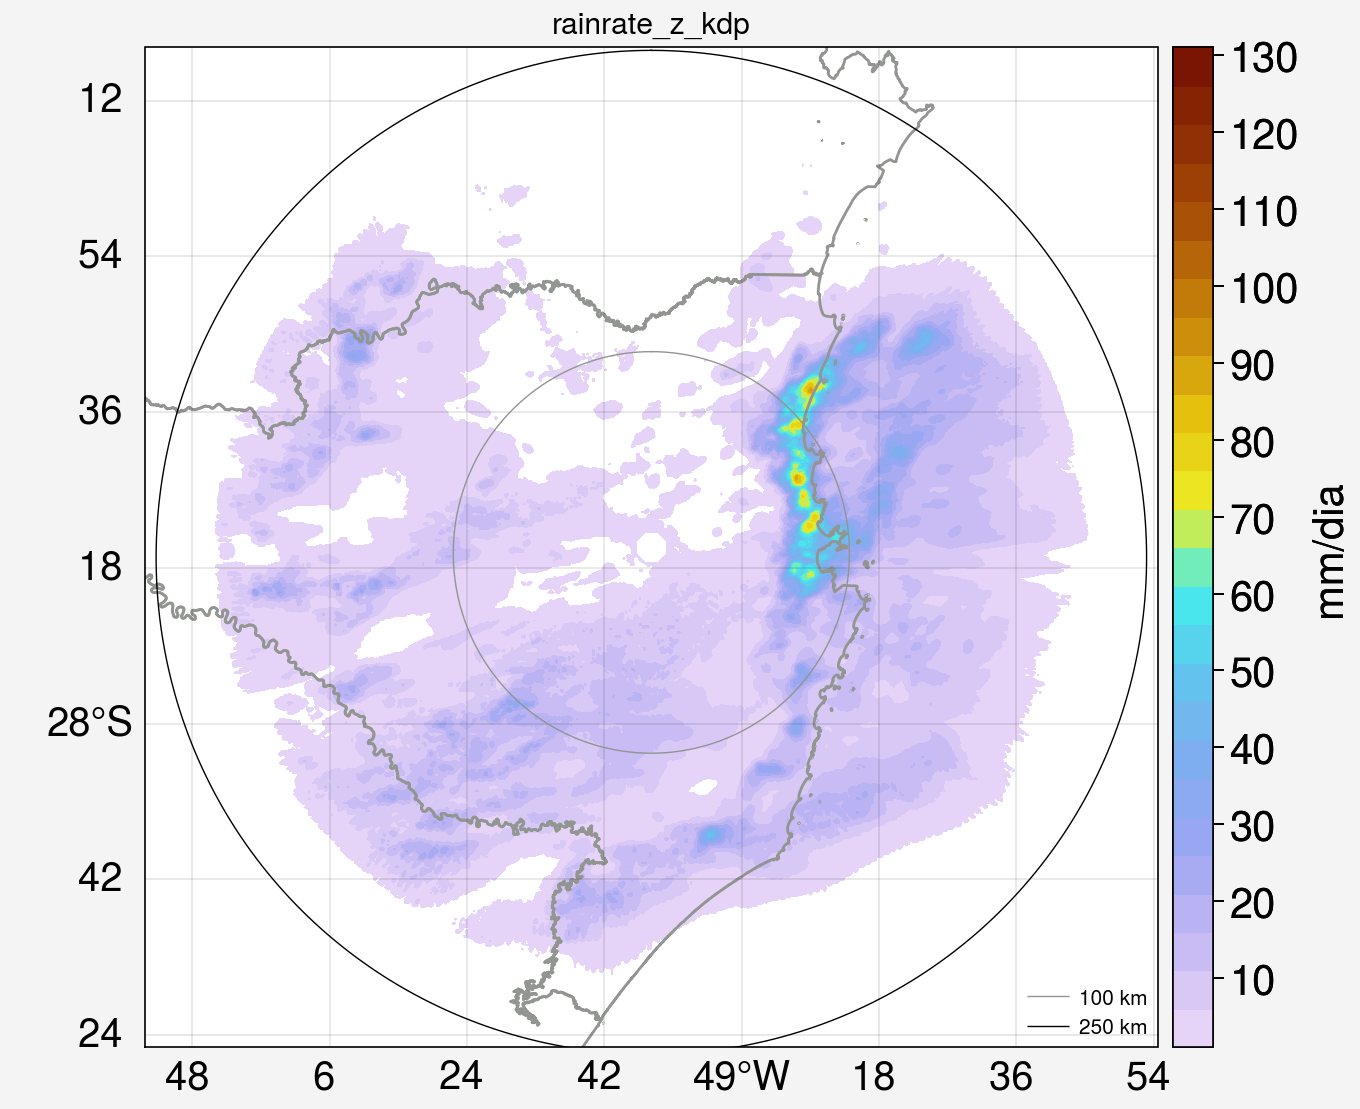

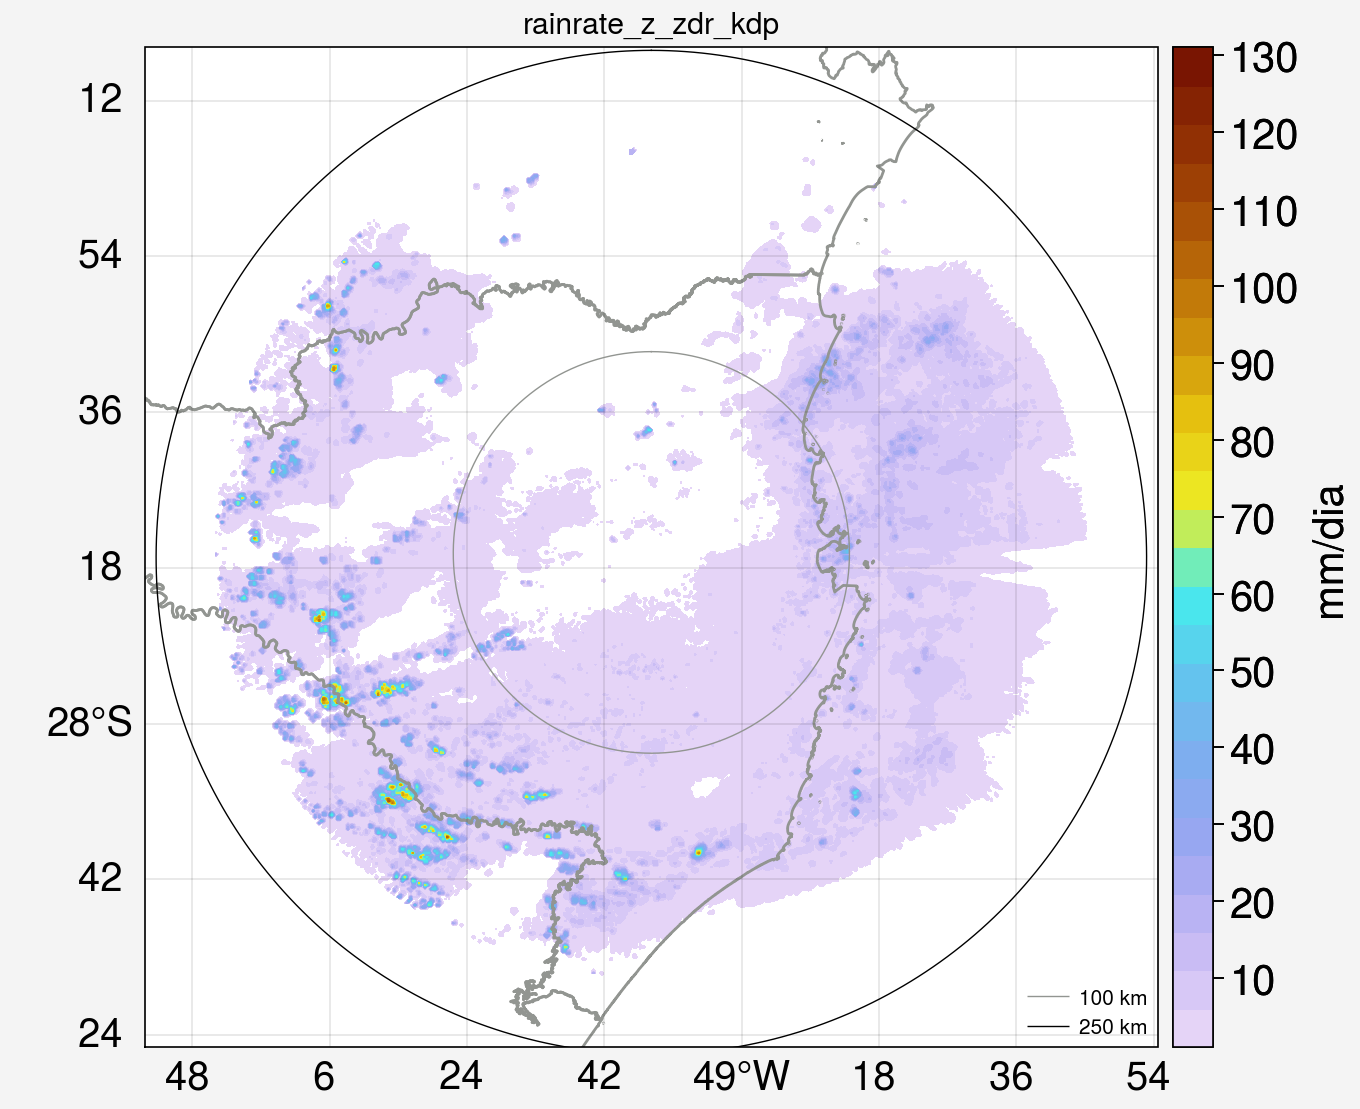

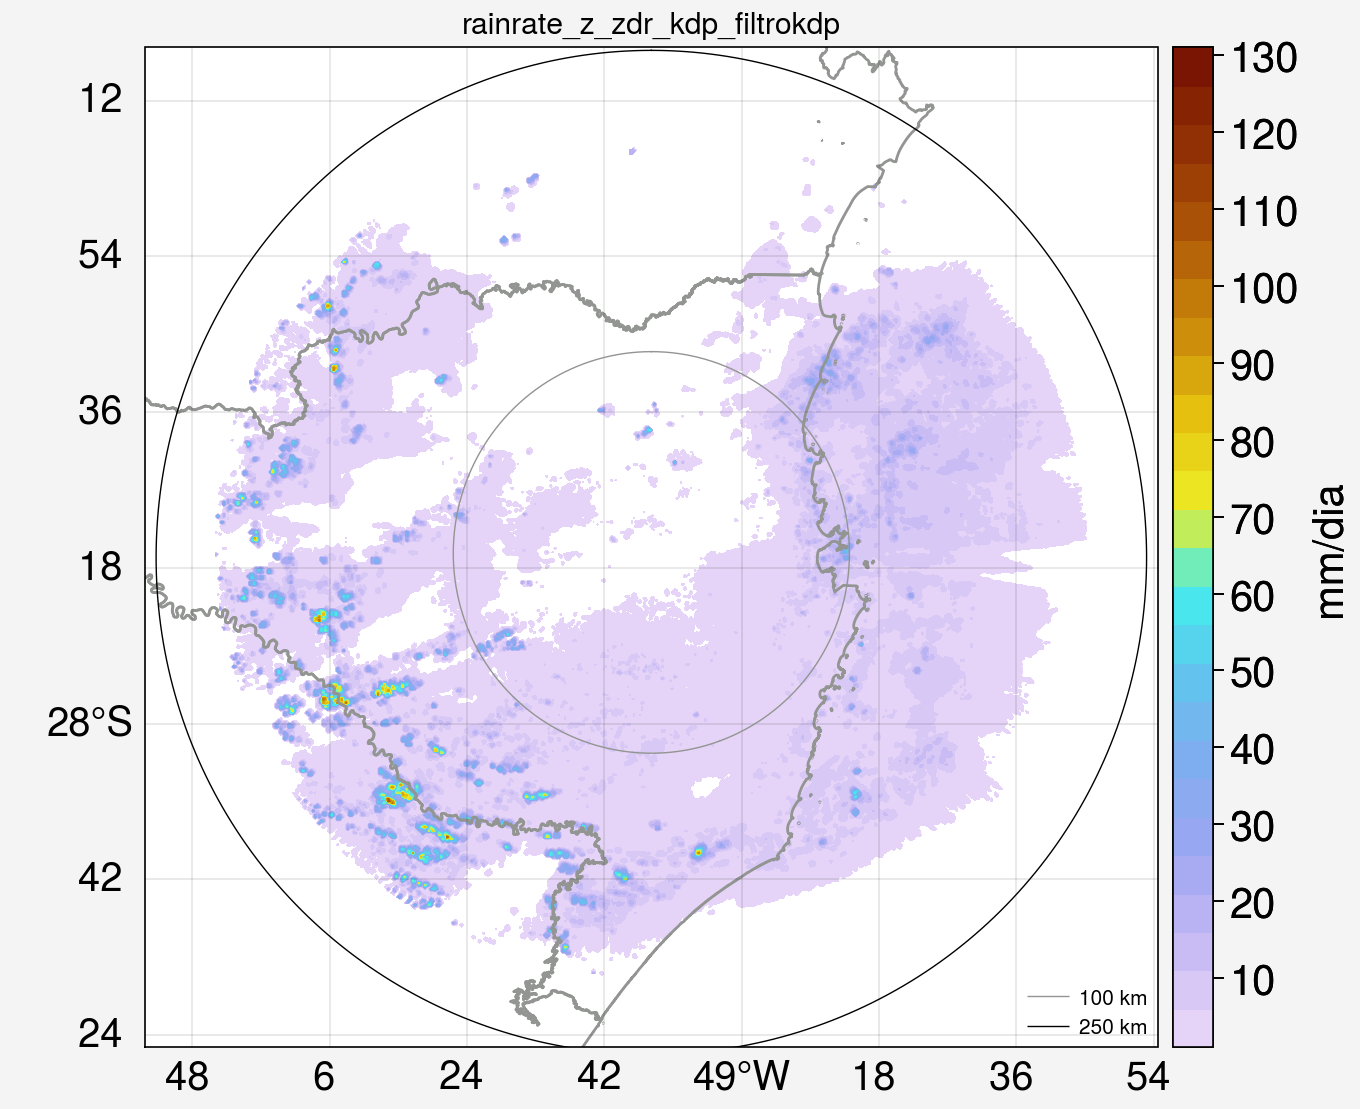

In [31]:
# importa bibliotecas
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import salem   

# localização do radar
lat_radar, lon_radar = -27.2301, -49.4610

# lista das estimativa de chuva
estimativas_chuva = ['rainrate_z', 
                     'rainrate_kdp', 
                     'rainrate_z_kdp', 
                     'rainrate_z_zdr_kdp', 
                     'rainrate_z_zdr_kdp_filtrokdp']

# soma a chuva dos dois dias 
for estimativa_chuva in estimativas_chuva:

    print(estimativa_chuva)

    # leitura dos arquivos
    chuva_dia = xr.open_dataset(f'output/06_ACUMULADO_PRECIPITACAO/chuva_acumulada_lontras_20230323_{estimativa_chuva}.nc')

    # cria moldura da figura
    fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

    # exatrai os limites dos dados de CAPPI
    lonmin, lonmax, latmin, latmax = float(ds['lon'].min()), float(ds['lon'].max()), float(ds['lat'].min()), float(ds['lat'].max())
    
    # formatação dos eixos
    ax.format(coast=False, borders=False, innerborders=False,
              labels=True,
              latlines=0.7, lonlines=0.7,
              title = f'{estimativa_chuva}',
              latlim=(latmin, latmax),
              lonlim=(lonmin, lonmax),
              small='20px',
              large='15px',
              abc=False)

    # plota mapa
    map1 = ax.contourf(chuva_dia['lon'],
                       chuva_dia['lat'],
                       chuva_dia['rain_acumulado_dia'][:,:],
                       cmap='pyart_LangRainbow12',
                       levels=pplt.arange(1, 130., 5),
                       vmin=1, vmax=130)
    #pyart_NWSRef
    #pyart_LangRainbow12

    #--------------------------#
    # aneis de distância do radar
    #--------------------------#
    evm_plota_aneis_em_geral([100], lon_radar, lat_radar, 'gray', label='100 km')
    evm_plota_aneis_em_geral([250], lon_radar, lat_radar, 'black', label='250 km')
    
    # plota o shapefile dos Estados
    estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/refs/heads/main/estados_do_brasil/BR_UF_2019.shp')    
    estados_selecionado = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SC' ) | (estados_brasil['SIGLA_UF'] == 'RS') | (estados_brasil['SIGLA_UF'] == 'PR')]
    estados_selecionado.plot(edgecolor='gray', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

    #--------------------------#
    #  barra de cor/legenda
    #--------------------------#
    fig.colorbar(map1, loc='r', label='mm/dia', ticks=10, ticklabelsize=15, labelsize=15, width=0.20, space=-5.2)

    # adiciona legenda
    ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':7.5}, markerscale=0.4)

    #--------------------------#
    #       salva figura
    #--------------------------#
    fig.save(f'output/06_ACUMULADO_PRECIPITACAO/chuva_acumulada_lontras_{estimativa_chuva}.png', dpi=300)